In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from sklearn.metrics import log_loss

In [2]:
(features_train, targets_train), (features_test, targets_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


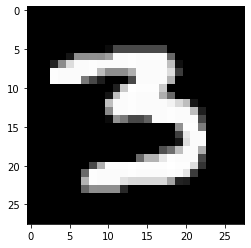

Label: 3


In [3]:
# Convert to float32.
X_train = features_train.astype(np.float32)
X_test = features_test.astype(np.float32)

# Flatten images to 1-D vector of 784 features (28*28).
temp_train = []
for i in range(len(X_train)):
  temp_train.append(X_train[i].flatten())

X_train = np.array(temp_train)

temp_test = []
for i in range(len(X_test)):
  temp_test.append(X_test[i].flatten())

X_test = np.array(temp_test)

# Normalize images value from [0, 255] to [0, 1].
X_train = X_train / np.ptp(X_train)
X_test = X_test / np.ptp(X_test)

# create feature and targets tensor for train set. As we need variable to accumulate gradients.
# Therefore first we create tensor, then we will create variable
features_train = torch.from_numpy(X_train)
targets_train = torch.from_numpy(targets_train)

# create feature and targets tensor for test set.
features_test = torch.from_numpy(X_test)
targets_test = torch.from_numpy(targets_test)

# batch_size, epoch and iteration
batch_size = 100
n_iters = 5000
num_epochs = int(n_iters / (len(features_train) / batch_size))

# Pytorch train and test sets - Tensordataset
train_data = TensorDataset(features_train, targets_train)
test_data = TensorDataset(features_test, targets_test)

# data loader
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=True)

# visualize one of the images in data set
train_features, train_labels = next(iter(train_loader))
img = train_features[0].view(28, 28).squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [4]:
# Create ANN Model
class ANNModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(ANNModel, self).__init__()
    self.d1 = nn.Linear(input_dim, hidden_dim)
    self.d2 = nn.Linear(hidden_dim, output_dim)
  
  def forward(self, x):
    x = nn.functional.relu(self.d1(x))
    x = self.d2(x)
    return torch.sigmoid(x)

# instantiate ANN
input_dim = 28*28
hidden_dim = 150 #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 10

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
features_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [6]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    train = Variable(images.view(-1, 28*28))
    labels = Variable(labels)
    pred = model(images)
    # Clear gradients
    optimizer.zero_grad()
    loss = error(pred, labels)
    # Forward propagation
    loss.backward()
    # Calculate softmax and cross entropy loss
    # Calculating gradients
    # Update parameters
    optimizer.step()
    count += 1
    if count % 50 == 0:
      # Calculate Accuracy
      correct = 0
      total = 0
      # Predict test dataset
      for images, labels in test_loader:
        test = Variable(images.view(-1, 28*28))
        # Forward propagation
        # Get predictions from the maximum value
        pred = model(test)
        # Total number of labels
        total, _ = pred.shape
        for i in range(total) :
          if np.argmax(pred[i].detach().numpy()) == labels[i] :
            correct += 1
      # Total correct predictions
      accuracy = correct / float(total)
      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)
      if count % 500 == 0:
        # Print Loss
        print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500 Loss: 2.1427037715911865 Accuracy: 73.13 %
Iteration: 1000 Loss: 1.8832182884216309 Accuracy: 80.26 %
Iteration: 1500 Loss: 1.829586148262024 Accuracy: 80.99 %
Iteration: 2000 Loss: 1.7420382499694824 Accuracy: 82.11 %
Iteration: 2500 Loss: 1.7207062244415283 Accuracy: 83.51 %
Iteration: 3000 Loss: 1.6794337034225464 Accuracy: 84.76 %
Iteration: 3500 Loss: 1.6845022439956665 Accuracy: 85.26 %
Iteration: 4000 Loss: 1.7256481647491455 Accuracy: 85.99 %
Iteration: 4500 Loss: 1.6655491590499878 Accuracy: 86.26 %


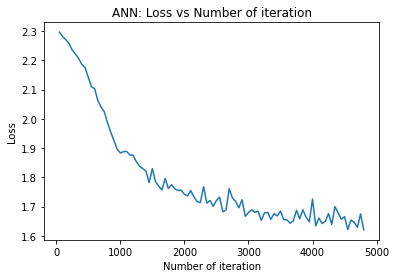

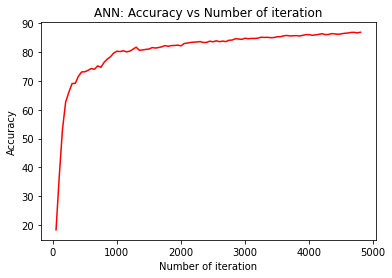

In [7]:
# visualization loss
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(iteration_list, accuracy_list, color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()